In [31]:
import torch
from datasets import load_dataset
import pandas as pd
import numpy as np
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import ast
from collections import Counter
import string
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud

#### Load data

In [3]:
cochrane=load_dataset("allenai/mslr2022","cochrane")

In [10]:
df=cochrane["train"].to_pandas()

In [12]:
df

,review_id,pmid,title,abstract,target
0,CD007697,[16394043],[Aggressive surgical effort and improved survi...,[Residual disease after initial surgery for ov...,We found only low quality evidence comparing u...
1,CD000174,"[8627434, 2677294, 3373404, 3321891, 8201485, ...",[Prophylactic indomethacin therapy in the firs...,[To determine whether a course of low-dose ind...,Prophylactic indomethacin has short-term benef...
2,CD008805,"[6024144, 4915981]",[White phosphorus burns and massive hemolysis....,"[nan, nan]",First aid for phosphorus burns involves the co...
3,CD000248,"[1159434, 14168625, 13969171, 14250709]",[Trial of long-term anticoagulant therapy in t...,[The clinical features of 49 patients who had ...,"Compared with control, there was no evidence o..."
4,CD004431,"[15240203, 11212135, 6487909, 3693660, 1269058...",[Computer-aided retraining of memory and atten...,[Cognitive compromise is one of the main contr...,The diversity of psychological interventions i...
...,...,...,...,...,...
3747,CD003416,"[16253973, 10527991, 15575055, 15618254, 11527...","[In unselected patients, elective single embry...",[Elective single embryo transfer (eSET) in a s...,"In a single fresh IVF cycle, SET is associated..."
3748,CD001009,[8033499],[Mecamylamine combined with nicotine skin patc...,[To evaluate concurrent administration of meca...,Data from two small studies suggest that the c...
3749,CD002835,"[11089633, 9871887, 9366579, 10703807, 1561471...",[Effect of short-course of antiretroviral agen...,"[nan, We examined our hospital-based occupatio...",The use of occupational PEP is based on limite...
3750,CD005186,"[12269760, 18538701, 9052110]","[Changing knowledge, behavior, and practice re...",[To evaluate the effect of an educational trai...,The quality of intervention studies intended t...


#### Word Counts

In [14]:
def count_words(text):
    try:
        # Convert NumPy array to string
        if isinstance(text, np.ndarray):
            text = text.item() if text.size == 1 else ' '.join(text)
        # Count words by splitting on whitespace
        return len(str(text).split())
    except Exception as e:
        print(f"Error counting words: {e}")
        return 0

def count_doc(text):
    return len(text)

In [37]:
# Calculate word counts
df['abstract_word_count'] = df['abstract'].apply(count_words)
df['target_word_count'] = df['target'].apply(count_words)

# Compute statistics
abstract_stats = df['abstract_word_count'].describe()
target_stats = df['target_word_count'].describe()

# Print statistics
print("Abstract Word Count Statistics:")
print(abstract_stats)
print("\nTarget Word Count Statistics:")
print(target_stats)

Abstract Word Count Statistics:
count      3752.000000
mean       2265.871269
std        3665.856846
min           1.000000
25%         559.750000
50%        1242.000000
75%        2680.500000
max      105540.000000
Name: abstract_word_count, dtype: float64

Target Word Count Statistics:
count    3752.000000
mean       67.784382
std        35.188302
min         7.000000
25%        43.000000
50%        61.000000
75%        86.000000
max       341.000000
Name: target_word_count, dtype: float64


#### Documents count

In [38]:
df['doc_count']=df["abstract"].apply(count_doc)
print("Number of documents statistic: ")
df["doc_count"].describe()

Number of documents statistic: 


count    3752.000000
mean       10.793443
std        17.143232
min         1.000000
25%         3.000000
50%         6.000000
75%        13.000000
max       537.000000
Name: doc_count, dtype: float64

#### Unigram, bigram, trigram frequency in target summary

In [23]:
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Top 10 Most Frequent Non-Stop Words in Target:
evidence: 2929
trials: 1972
treatment: 1504
studies: 1450
patients: 1244
may: 1170
use: 1165
review: 1010
effects: 939
effective: 872


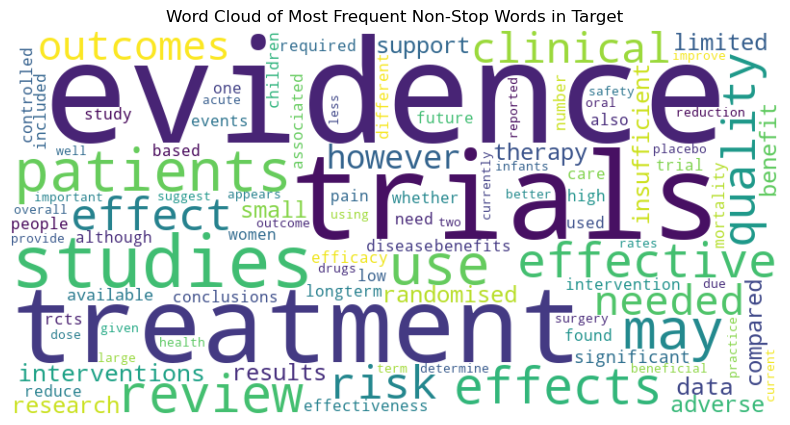

In [39]:
def get_non_stop_words(text):
    try:
        # Convert to string if necessary
        text = str(text)
        # Convert to lowercase, remove punctuation, and split into words
        words = text.lower().translate(str.maketrans('', '', string.punctuation)).split()
        # Remove stop words and filter out empty strings
        return [word for word in words if word and word not in stop_words]
    except Exception as e:
        print(f"Error processing text: {e}")
        return []

# Collect all non-stop words from the 'target' column
all_words = []
for target in df['target']:
    all_words.extend(get_non_stop_words(target))

# Count word frequencies
word_freq = Counter(all_words)

# Print the top 10 most frequent words for reference
top_words = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10])
print("\nTop 10 Most Frequent Non-Stop Words in Target:")
for word, freq in top_words.items():
    print(f"{word}: {freq}")

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      min_font_size=10,
                      max_words=100,
                      colormap='viridis').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Non-Stop Words in Target')
plt.show()

In [34]:
all_bigrams = []
all_trigrams = []
for target in df['target']:
    words = get_non_stop_words(target)
    # Generate bigrams and trigrams
    bigrams = list(ngrams(words, 2))
    trigrams = list(ngrams(words, 3))
    all_bigrams.extend(bigrams)
    all_trigrams.extend(trigrams)

# Count bigram and trigram frequencies
bigram_freq = Counter(all_bigrams)
trigram_freq = Counter(all_trigrams)

# Get the top 10 bigrams and trigrams
top_bigrams = dict(sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)[:20])
top_trigrams = dict(sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)[:20])

# Convert tuples to strings for visualization
top_bigrams = { ' '.join(k): v for k, v in top_bigrams.items() }
top_trigrams = { ' '.join(k): v for k, v in top_trigrams.items() }

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26704\3856413161.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_bigrams.values()), y=list(top_bigrams.keys()), palette='magma')


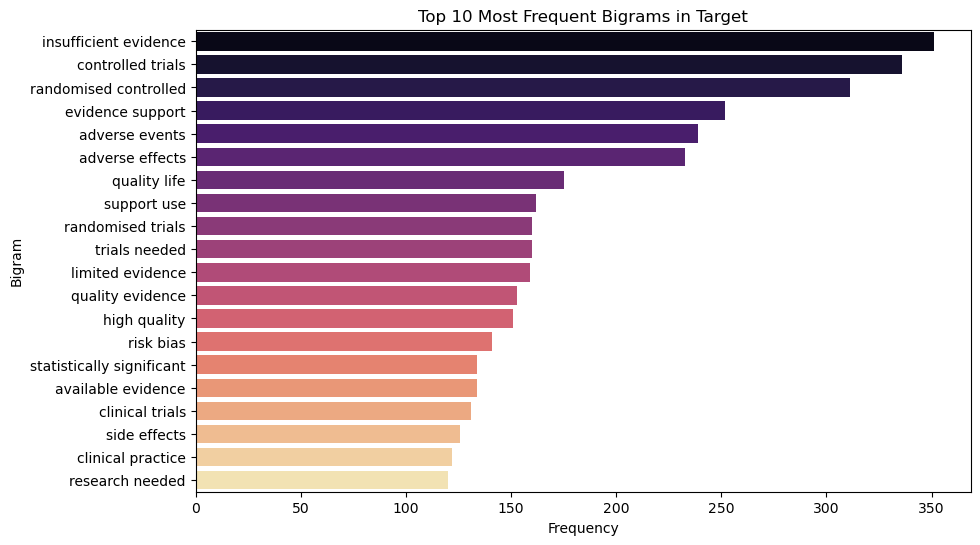

In [ ]:
# Visualize bigrams with a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(top_bigrams.values()), y=list(top_bigrams.keys()), palette='magma')
plt.title('Top Most Frequent Bigrams in Target')
plt.xlabel('Frequency')
plt.ylabel('Bigram')

plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26704\3787173667.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_trigrams.values()), y=list(top_trigrams.keys()), palette='magma')


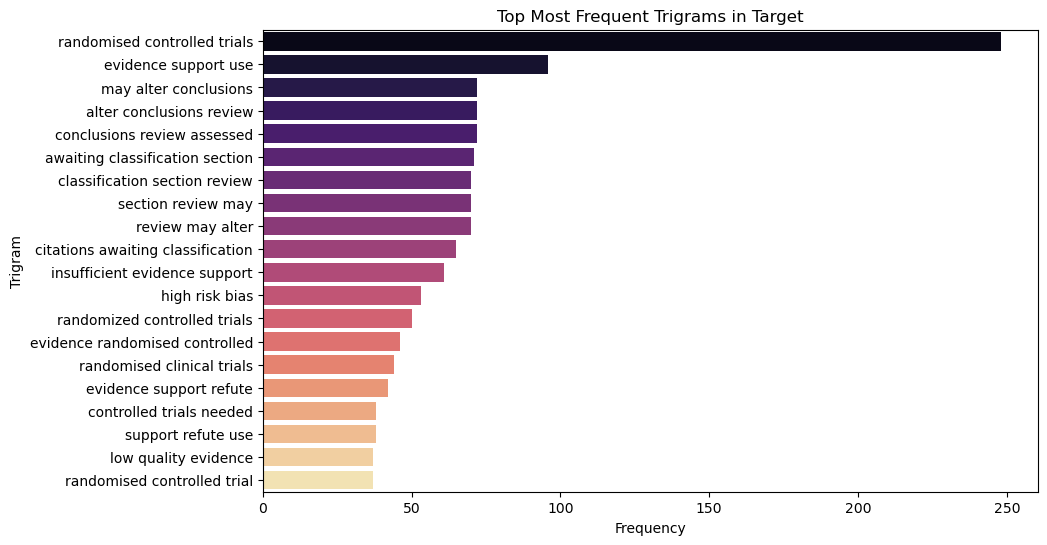

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(top_trigrams.values()), y=list(top_trigrams.keys()), palette='magma')
plt.title('Top Most Frequent Trigrams in Target')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.show()